In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
torch.manual_seed(1212)
torch.cuda.manual_seed(1212)
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu' #for use in debugging

In [2]:
unpruned = pd.read_csv('cars_unpruned.csv',encoding='cp1252',index_col=0)
unpruned.head()

,Rating,Gas Mileage,Engine,EPA Class,Style Name,Drivetrain,Passenger Capacity,Passenger Doors,Body Style,Transmission,...,Basic Miles/km,Basic Years,Corrosion Miles/km,Corrosion Years,Drivetrain Miles/km,Drivetrain Years,Hybrid/Electric Components Miles/km,Hybrid/Electric Components Years,Roadside Assistance Miles/km,Roadside Assistance Years
Name,,,,,,,,,,,,,,,,,,,,,
2021 Kia Niro,6,51 mpg City/46 mpg Hwy,"Gas/Electric I-4, 1.6 L",Small Station Wagons,EX Premium FWD,Front Wheel Drive,5,4,Sport Utility,Transmission: 6-Speed Dual-Clutch -inc: sport ...,...,"60,000",5,"100,000",5.0,"100,000",10,"100,000",10.0,"60,000",5
2021 Tesla Model 3,8,NaN,Electric,Midsize Cars,Long Range AWD,All Wheel Drive,5,4,4dr Car,Transmission: 1-Speed Automatic,...,"50,000",4,Unlimited,12.0,"120,000",8,NaN,NaN,"50,000",4
2020 Tesla Model S,8,NaN,Electric,Large Cars,Long Range AWD *Ltd Avail*,All Wheel Drive,5,4,4dr Car,Transmission: 1-Speed Automatic,...,"50,000",4,Unlimited,12.0,Unlimited,8,NaN,NaN,"50,000",4
2021 Chevrolet Bolt EV,7,NaN,"Electric,",Small station wagon,5dr Wgn LT,Front Wheel Drive,5,4,4dr Car,NaN,...,"36,000",3,"100,000",6.0,"60,000",5,"100,000",8.0,"60,000",5
2021 Ford Mustang Mach-E,9,NaN,Electric,Small Station Wagons,California Route 1 RWD,Rear Wheel Drive,5,4,Sport Utility,Transmission: Single Speed,...,"36,000",3,Unlimited,5.0,"60,000",5,"24,000",2.0,"60,000",5


Here we can see a small sample of the unpruned data set, and the values of a handful of the input parameters.
As you can see, there would be 109 input parameters for each of the 215 samples, but many of them are not
relevant to this question, eg gas mileage or part order numbers. We can then take a look at the pruned dataset:

In [3]:
data = pd.read_csv('cars.csv',encoding='cp1252',index_col=0)
data.head()

,Rating,Engine,EPA Class,Drivetrain,Body Style,Brake Type,Front Wheel Material,Rear Wheel Material,Suspension Type - Front,Suspension Type - Rear,...,Drivetrain Years,Air Bag-Side Body-Rear,Air Bag-Side Head-Front,Air Bag-Side Head-Rear,Child Safety Rear Door Locks,Daytime Running Lights,Rollover Protection Bars,Fog Lamps,Parking Aid,Back-Up Camera
Name,,,,,,,,,,,,,,,,,,,,,
2021 Kia Niro,6,"Gas/Electric I-4, 1.6 L",Small Station Wagon,Front Wheel Drive,Sport Utility,4-Wheel Disc,Aluminum,Aluminum,Strut,Multi-Link,...,10,No,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes
2021 Tesla Model 3,8,Electric,Midsize,All Wheel Drive,4dr Car,4-Wheel Disc,Aluminum,Aluminum,Double Wishbone,Multi-Link,...,8,No,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes
2020 Tesla Model S,8,Electric,Large Cars,All Wheel Drive,4dr Car,4-Wheel Disc,Aluminum,Aluminum,Double Wishbone,Multi-Link,...,8,No,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes
2021 Chevrolet Bolt EV,7,Electric,Small Station Wagon,Front Wheel Drive,4dr Car,Partially Regenerative Electro-Hydraulic,Aluminum,Aluminum,MacPherson Strut,Compound Crank (Torsion Beam),...,5,Yes,Yes,Yes,Yes,Yes,No,No,No,Yes
2021 Ford Mustang Mach-E,9,Electric,Small Station Wagon,Rear Wheel Drive,Sport Utility,4-Wheel Disc,Aluminum,Aluminum,Strut,Multi-Link,...,5,Yes,Yes,Yes,Yes,Yes,No,No,No,Yes


As we can see, this is now a dataframe with only relevant data, using 40 input parameters.
From here, we can turn it into a proper Pytorch dataset

In [4]:
class CarDataset(Dataset):
    
    def __init__(self, data):
        ohe = OneHotEncoder()
        lb = LabelBinarizer()
        y = data.iloc[:,0].values
        x = data.iloc[:,1:].values
        
        y_labels = []
        for i in range(len(y)):
            try:
                ind = y_labels.index(y[i])

            except ValueError:
                y_labels.append(y[i])


        y_labels = sorted(y_labels)
        for i in range(len(y)):
            ind = y_labels.index(y[i])
            y[i] = ind
        
        
        xen = ohe.fit_transform(x[:,0:9]).toarray()
        print(xen.shape[1])
        xtran = lb.fit_transform(x[:,9].astype('int'))
        print(xtran.shape[1])
        mins = []
        maxs = []
        for i in range(10,31):
            mincurr = np.min(x[:,i])
            maxcurr = np.max(x[:,i])
            mins.append(mincurr)
            maxs.append(maxcurr)
            for j in range(len(x[:,0])):
                x[j,i] = (x[j,i]-mincurr)/(maxcurr-mincurr)
        
        xnorm = x[:,10:30]
        for j in range(31,40):
            for i in range(len(x[:,j])):
                if (x[i,j]=="Yes"):
                    x[i,j] = 1
                elif (x[i,j] == "No"):
                    x[i,j] = -1
        xbin = x[:,31:40]
        print(xbin.shape[1])
        print(xbin.shape[0])
        x = np.concatenate([xen,xtran],axis=1)
        x = np.concatenate([x,xnorm],axis=1)
        x = np.concatenate([x,xbin],axis=1)
        x = x.astype('float64')
        y.astype('long')
        self.y = y
        self.x = x
        self.labels = y_labels
        self.enc = ohe
        self.mins = np.asarray(mins)
        self.maxs = np.asarray(maxs)
        self.lb = lb
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def getlabels(self):
        return self.labels
    def categories(self):
        return self.enc.categories_
    def mins (self):
        return self.mins
    def maxs (self):
        return self.maxs
    def enc (self):
        return self.enc
    def lb (self):
        return self.lb

In [5]:
data_set = CarDataset(data)
xitem, yitem = data_set.__getitem__(0)
input_dim = xitem.shape[0]
print("Input Dimensions: ",input_dim)

106
8
9
215
Input Dimensions:  143


Here are the sizes of each of the tensors that will be concatenated into our final dataset, displayed for the sake of visualization while designing later functions. We can also see that the parameter space has expanded from the original 40 parameters, into 143 due to encoding.

In [6]:
data_set.categories()

[array(['Electric', 'Gas I3, 1.0', 'Gas I4, 1.2L', 'Gas I4, 1.4L',
        'Gas I4, 2.5L', 'Gas I6, 3.0L', 'Gas/Electric I-4, 1.5 L',
        'Gas/Electric I-4, 1.6 L', 'Gas/Electric I-4, 1.8 L',
        'Gas/Electric I-4, 2.0 L', 'Gas/Electric I-4, 2.5 L',
        'Gas/Electric I4, 1.5L', 'Gas/Electric I4, 1.8L',
        'Gas/Electric I4, 2.4L', 'Gas/Electric V-6, 3.5 L',
        'Gas/Electric V-6, 3.6 L', 'Gas/Electric, 1.4L',
        'Intercooled Supercharger Premium Unleaded V-8, 5.0 L',
        'Intercooled Turbo Diesel I-6, 3.0 L',
        'Intercooled Turbo Gas/Electric I-3, 1.5 L',
        'Intercooled Turbo Gas/Electric I-4, 2.0 L',
        'Intercooled Turbo Gas/Electric I-6, 3.0 L',
        'Intercooled Turbo Gas/Electric V-6, 3.0 L',
        'Intercooled Turbo Premium Unleaded I-4, 1.8 L',
        'Intercooled Turbo Premium Unleaded I-4, 2.0 L',
        'Intercooled Turbo Premium Unleaded I-4, 2.3 L',
        'Intercooled Turbo Premium Unleaded I-6, 3.0 L',
        'Interco

Here are the categorical parameters which will be one-hot encoded, displayed to ensure there are no repititions or unnecessary elements. 

In [7]:
output_dim = len(data_set.getlabels())
print ('Output Dimensions:',output_dim)
data_set.getlabels()

Output Dimensions: 5


[5, 6, 7, 8, 9]

Here is the vector of output labels, corresponding to car ratings

We can then design each of the neural networks to be used:

In [8]:
class Labeler(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(Labeler, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim,1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,output_dim),
        )
    def forward(self,x):
        output = self.model(x)
        return output

In [9]:
class Discriminator(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim,1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        output = self.model(x)
        return output

In [10]:
class Generator(nn.Module):
    def __init__(self,input_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,input_dim),
            nn.Tanh()
        )
    def forward(self,x):
        output = self.model(x)
        return output

In [11]:

D = Discriminator(input_dim,output_dim)
D = D.to(device)

G = Generator(input_dim)
G = G.to(device)

L = Labeler(input_dim,output_dim)
L = L.to(device)

In [12]:
lr = 0.001 #learning rate
criterion = nn.BCELoss() #binary cross entropy loss
criterion = criterion.to(device)
crossen = nn.CrossEntropyLoss() #cross entropy loss
crossen = crossen.to(device)

In [13]:
#Adam Optimizers
D_opt = optim.Adam(D.parameters(), lr=lr)
G_opt = optim.Adam(G.parameters(),lr=lr)
L_opt = optim.Adam(L.parameters(), lr=0.0001)

In [14]:
batch_size = 5
data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle = True)

In [15]:
#Function to generate cars and decode the data

def generate_cars(G,latent_v,categories, mins, maxs, y_labels,enc,lb):
    #generate samples and labels
    with torch.no_grad():
        cars = G(latent_v)
        labels = L(cars)
    cars = cars.cpu()
    labels = labels.cpu()
    cars = cars.detach().numpy()
    count = 0
    num = 114
    
    #de-normalize normalized data
    for i in range(num,num+21):
        for j in range(len(cars[:,0])):
            cars[j,i] = cars[j,i]*(maxs[count]-mins[count])+mins[count]
        count = count+1
    
    #make data readable for one-hot encoder
    cars[:,0:106] = np.round(abs(cars[:,0:106]))
    cars[:,106:114] = np.round(abs(cars[:,106:114]))
    
    predicted = torch.argmax(labels, dim=1)
    for i in range(len(labels)):
        print("Car ",i+1)
        print("Rating: ",y_labels[predicted[i]])
        #decode data
        cats = enc.inverse_transform([cars[i,0:106]])
        trans = lb.inverse_transform(np.asarray([cars[i,106:114]]))
        bins = []
        for n in cars[i,(num+20):]:
            if (i<0):
                bins.append('No')
            else:
                bins.append('Yes')
        
        #print out formated specifications
        print("Engine Type: ", cats[0][0], "; EPA Class: ",cats[0][1], "; Transmission Type: ",trans[0])
        print("Drivetrain: ",cats[0][2], "; Body Style: ",cats[0][3], "; Brake Type: ", cats[0][4])
        print("Front Wheel Material: ",cats[0][5],"; Rear Wheel Material: ",cats[0][6])
        print("Suspension Type - Front: ",cats[0][7], "; Suspension Type - Rear: ",cats[0][8])
        print("Passengers: ",round(cars[i,num]), "; Passenger Doors: ",round(cars[i,num+1]), "; Base Curb Weight: ",cars[i,num+2])
        print("Front Leg Room(in): ",cars[i,num+3], "; Front Shoulder room(in): ",cars[i,num+4])
        print("Front Head Room(in): ",cars[i,num+5],"; Track Width - Front: ",cars[i,num+10],"; Track Width - Rear",cars[i,num+7])
        print("Height: ",cars[i,num+8],"; Length: ",cars[i,num+9],"; Wheelbase: ",cars[i,num+6],"; Width Max w/o Mirrors: ",cars[i,num+11])
        print("SAE Net Horsepower: ",cars[i,num+12],"; Rear Break Ratio: ",cars[i,num+13],"; Front Break Ratio: ",cars[i,num+14])
        print("Front Wheel Size: ",cars[i,num+15],"; Rear Wheel Size: ",cars[i,num+16], "; Basic Miles: ",cars[i,num+17])
        print("Corrorsion Years: ",cars[i,num+18],"; Drivetrain Years: ",cars[i,num+19])
        print("Air Bag-Side Body-Rear: ",bins[0],"; Air Bag-Side Head-Front: ",bins[1],"; Air Bag-Side Head-Rear: ",bins[2])
        print("Child Safety Rear Door Locks: ",bins[3],"; Daytime Running Lights: ",bins[4], "; Rollover Protection Bars: ",bins[5])
        print("Fog Lamps: ",bins[6],"; Parking Aid: ",bins[7],"; Back-Up Camera: ",bins[8])
        print("")

In [16]:
num_epochs = 500

In [17]:
#Train Labeler

L_loss_hist = []
L_acc_hist = []
for epoch in range(num_epochs):
    L_accs = []
    L_losses = []
    for batch, (real_samples,real_labels) in enumerate(data_loader):
        real_samples = real_samples.float().to(device)
        real_labels = real_labels.long().to(device)
        
        L.zero_grad()
        yhat = L(real_samples)
        L_loss = crossen(yhat,real_labels)
        predclass = torch.argmax(yhat,dim=1)
        L_acc = torch.mean((predclass==real_labels).float())
        L_loss.backward()
        L_opt.step()
        L_accs.append(L_acc)
        L_losses.append(L_loss)
    if ((epoch+1)%20==0):
        print(f"Epoch: {epoch+1} Label Accuracy: {torch.mean(torch.FloatTensor(L_accs))} Label Loss: {torch.mean(torch.FloatTensor(L_losses))}")
    L_loss_hist.append(torch.mean(torch.FloatTensor(L_losses)))
    L_acc_hist.append(torch.mean(torch.FloatTensor(L_accs)))

Epoch: 20 Label Accuracy: 0.8651161789894104 Label Loss: 0.4260060489177704
Epoch: 40 Label Accuracy: 0.9069767594337463 Label Loss: 0.21319398283958435
Epoch: 60 Label Accuracy: 0.9209302067756653 Label Loss: 0.16846543550491333
Epoch: 80 Label Accuracy: 0.9069768190383911 Label Loss: 0.17947445809841156
Epoch: 100 Label Accuracy: 0.9209302067756653 Label Loss: 0.15103314816951752
Epoch: 120 Label Accuracy: 0.930232584476471 Label Loss: 0.14129270613193512
Epoch: 140 Label Accuracy: 0.9116279482841492 Label Loss: 0.13800540566444397
Epoch: 160 Label Accuracy: 0.9162790179252625 Label Loss: 0.1476934403181076
Epoch: 180 Label Accuracy: 0.9209302663803101 Label Loss: 0.13262225687503815
Epoch: 200 Label Accuracy: 0.9162790775299072 Label Loss: 0.13367195427417755
Epoch: 220 Label Accuracy: 0.9348836541175842 Label Loss: 0.13103124499320984
Epoch: 240 Label Accuracy: 0.9162790775299072 Label Loss: 0.12910780310630798
Epoch: 260 Label Accuracy: 0.9209302067756653 Label Loss: 0.11939862370

In [18]:
#target vectors for BCE loss

target_ones = torch.ones((batch_size, 1), device=device)
target_zeros = torch.zeros((batch_size, 1), device=device)

In [19]:
#Train GAN

D_loss_hist = []
G_loss_hist = []
noise = lambda n: torch.randn((n,100), device = device)


for epoch in range(num_epochs):
    D_losses = []
    G_losses = []
    for batch, (real_samples, real_labels) in enumerate(data_loader):
        real_samples = real_samples.float().to(device)
        real_labels = real_labels.long().to(device)
        latent_v = noise(batch_size)
        
        #discr train
        D.zero_grad()
        pred_real = D(real_samples)
        loss_real = criterion(pred_real, target_ones)
        loss_real.backward()
        with torch.no_grad():
            fake_samples = G(latent_v)
        pred_fake = D(fake_samples)
        loss_fake = criterion(pred_fake, target_zeros)
        loss_fake.backward()
        loss = (loss_real+loss_fake)/2
        D_opt.step()
        D_losses.append(loss)
        #gen train
        G.zero_grad()
        generated_samples = G(latent_v)
        classes = D(generated_samples)
        genloss = criterion(classes,target_ones)
        genloss.backward()
        G_opt.step()
        G_losses.append(genloss)

    
    if ((epoch+1)%20==0):
        print(f"Epoch: {epoch+1} Discriminator Loss: {torch.mean(torch.FloatTensor(D_losses))} Generator Loss: {torch.mean(torch.FloatTensor(G_losses))}")
    D_loss_hist.append(torch.mean(torch.FloatTensor(D_losses)))
    G_loss_hist.append(torch.mean(torch.FloatTensor(G_losses)))

Epoch: 20 Discriminator Loss: 0.2827947735786438 Generator Loss: 4.45574426651001
Epoch: 40 Discriminator Loss: 0.13381949067115784 Generator Loss: 3.8835463523864746
Epoch: 60 Discriminator Loss: 0.12543734908103943 Generator Loss: 2.711602210998535
Epoch: 80 Discriminator Loss: 0.08431985974311829 Generator Loss: 5.346671104431152
Epoch: 100 Discriminator Loss: 0.1690155267715454 Generator Loss: 3.462733030319214
Epoch: 120 Discriminator Loss: 0.1316514015197754 Generator Loss: 2.8877663612365723
Epoch: 140 Discriminator Loss: 0.12576551735401154 Generator Loss: 3.00962233543396
Epoch: 160 Discriminator Loss: 0.1527135670185089 Generator Loss: 2.9360549449920654
Epoch: 180 Discriminator Loss: 0.19427262246608734 Generator Loss: 2.728646993637085
Epoch: 200 Discriminator Loss: 0.1082947626709938 Generator Loss: 3.8925492763519287
Epoch: 220 Discriminator Loss: 0.11869917064905167 Generator Loss: 3.5762670040130615
Epoch: 240 Discriminator Loss: 0.10188431292772293 Generator Loss: 4.34

Text(0, 0.5, 'Loss')

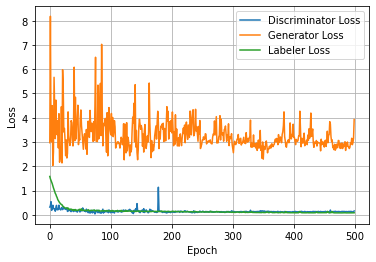

In [20]:
plt.plot(range(num_epochs),D_loss_hist,label="Discriminator Loss")
plt.plot(range(num_epochs),G_loss_hist,label="Generator Loss")
plt.plot(range(num_epochs),L_loss_hist,label="Labeler Loss")
plt.legend()
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [22]:
#Extract the relevant elements from the dataset and run generator function
categories = data_set.categories()
mins = data_set.mins
maxs = data_set.maxs
labels = data_set.getlabels()
enc = data_set.enc
lb = data_set.lb
batch = noise(5)
generate_cars(G,batch,categories, mins, maxs, labels,enc,lb)

Car  1
Rating:  7
Engine Type:  Gas/Electric I-4, 1.5 L ; EPA Class:  Midsize ; Transmission Type:  1
Drivetrain:  Front Wheel Drive ; Body Style:  4dr Car ; Brake Type:  4-Wheel Disc
Front Wheel Material:  Aluminum ; Rear Wheel Material:  Aluminum
Suspension Type - Front:  Strut ; Suspension Type - Rear:  Multi-Link
Passengers:  4 ; Passenger Doors:  4 ; Base Curb Weight:  3168.453
Front Leg Room(in):  42.32199 ; Front Shoulder room(in):  53.30109
Front Head Room(in):  39.18421 ; Track Width - Front:  61.974094 ; Track Width - Rear 61.407085
Height:  57.460377 ; Length:  183.07585 ; Wheelbase:  112.87588 ; Width Max w/o Mirrors:  71.90969
SAE Net Horsepower:  223.8666 ; Rear Break Ratio:  10.019889 ; Front Break Ratio:  11.717636
Front Wheel Size:  112.25632 ; Rear Wheel Size:  119.41868 ; Basic Miles:  32217.443
Corrorsion Years:  2.6966412 ; Drivetrain Years:  4.9450684
Air Bag-Side Body-Rear:  Yes ; Air Bag-Side Head-Front:  Yes ; Air Bag-Side Head-Rear:  Yes
Child Safety Rear Door

As we can see, the generated samples are representative of the average elements of the dataset